In [1]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
# import faiss
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
LOCAL_DATA_PATH = 'E:/mts/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit_2.pqt'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [5]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

,field,type
0,region_name,string
1,city_name,string
2,cpe_manufacturer_name,string
3,cpe_model_name,string
4,url_host,string
5,cpe_type_cd,string
6,cpe_model_os_type,string
7,price,double
8,date,date32[day]
9,part_of_day,string


Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [6]:
data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

smartphone    322781599
tablet            53768
plain             36116
phablet           27952
Name: cpe_type_cd, dtype: int64

In [7]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [8]:
%%time
data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
    group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])

CPU times: total: 20.7 s
Wall time: 20.7 s


In [9]:
data_agg

pyarrow.Table
request_cnt_sum: int64
user_id: int64
url_host: string
----
request_cnt_sum: [[12,491,174,305,446,...,1,1,1,1,2]]
user_id: [[45098,45098,45098,45098,45098,...,300964,300964,300964,300964,300964]]
url_host: [["ad.adriver.ru","apple.com","avatars.mds.yandex.net","googleads.g.doubleclick.net","i.ytimg.com",...,"youtube.com","biosfera.kz","chihuahuadog-ru.turbopages.org","sun9-88.userapi.com","showjet.ru"]]

In [10]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [27]:
%%time
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 50, iterations = 30, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: total: 4.89 s
Wall time: 4.9 s


In [23]:
%%time
als.fit(mat)
u_factors = als.model.user_factors 
d_factors = als.model.item_factors

CPU times: total: 0 ns
Wall time: 0 ns


## Получим оценку по полу

In [30]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: total: 172 ms
Wall time: 177 ms


Series([], Name: is_male, dtype: int64)

In [33]:
df

,age,is_male,user_id


In [34]:
%%time
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')

ValueError: With n_samples=0, test_size=0.33 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [20]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]

## Получим оценку по возрасту

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [22]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot: xlabel='age', ylabel='Count'>

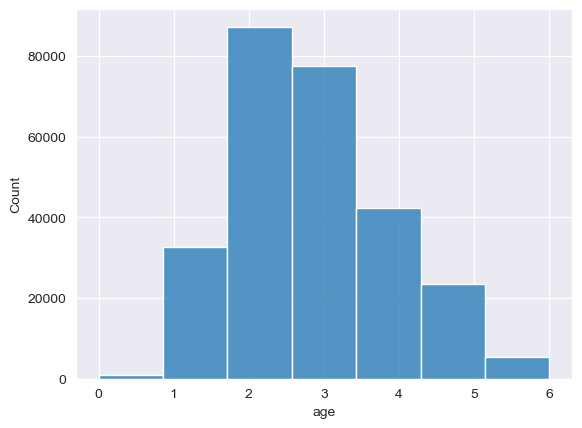

In [23]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.50      0.00      0.01       349
       18-25       0.50      0.29      0.37     10663
       25-34       0.47      0.62      0.53     28815
       35-44       0.39      0.52      0.44     25791
       45-54       0.36      0.18      0.24     13931
       55-65       0.40      0.19      0.25      7688
         65+       0.25      0.01      0.02      1849

    accuracy                           0.43     89086
   macro avg       0.41      0.26      0.27     89086
weighted avg       0.42      0.43      0.41     89086



In [25]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

## Сабмит

In [26]:
id_to_submit.head()

,user_id,is_male,age
221301,221301,0.947033,2
31271,31271,0.524296,3
211594,211594,0.511134,2
253119,253119,0.494311,3
192578,192578,0.810764,2


In [27]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)

In [28]:
! head $LOCAL_DATA_PATH/submission.csv

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


# Скор на лидерборде

In [29]:
context_scorer(submission, answers)

NameError: name 'context_scorer' is not defined